## **Prediksi kategori tingkat keparahan kecelakaan atau korban menggunakan Decission Tree**

### Import Library

In [97]:
# Cell 1: Import Library
import csv
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import log2
from prettytable import PrettyTable 
import matplotlib.pyplot as plt

### Kode fungsi perhitungan data

In [98]:
# Cell 2: Fungsi Load Data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append(row)
    return data

# Cell 3: Fungsi Pilih Data Acak
def select_random_data(data, num_samples=1000):
    if len(data) < num_samples:
        raise ValueError("Jumlah data kurang dari jumlah sampel yang diinginkan.")
    return random.sample(data, num_samples)

# Cell 4: Fungsi Menghitung Entropy
def entropy(data, target_attr):
    total = len(data)
    counts = {}
    for row in data:
        key = row[target_attr]
        if key not in counts:
            counts[key] = 0
        counts[key] += 1
    return -sum((count / total) * log2(count / total) for count in counts.values())

# Cell 5: Fungsi Menghitung Information Gain
def information_gain(data, attr, target_attr):
    total_entropy = entropy(data, target_attr)
    subsets = {}
    for row in data:
        key = row[attr]
        if key not in subsets:
            subsets[key] = []
        subsets[key].append(row)
    weighted_entropy = sum((len(subset) / len(data)) * entropy(subset, target_attr) for subset in subsets.values())
    return total_entropy - weighted_entropy, total_entropy, weighted_entropy

# Cell 6: Fungsi Membangun Decision Tree
def build_tree(data, attributes, target_attr):
    counts = {row[target_attr]: 0 for row in data}
    for row in data:
        counts[row[target_attr]] += 1
    if len(counts) == 1:
        return next(iter(counts))
    if not attributes:
        return max(counts, key=counts.get)

    gains = {attr: information_gain(data, attr, target_attr) for attr in attributes}
    best_attr = max(gains, key=lambda k: gains[k][0])
    tree = {best_attr: {}}
    subsets = {}
    for row in data:
        key = row[best_attr]
        if key not in subsets:
            subsets[key] = []
        subsets[key].append(row)
    for attr_val, subset in subsets.items():
        subtree = build_tree(subset, [attr for attr in attributes if attr != best_attr], target_attr)
        tree[best_attr][attr_val] = subtree
    tree['Information Gain'] = gains[best_attr][0]
    return tree

# Cell 7: Fungsi Prediksi
def predict(tree, instance):
    if not isinstance(tree, dict):
        return tree
    attr, branches = next(iter(tree.items()))
    if attr == 'Information Gain':
        return None
    attr_val = instance.get(attr)
    subtree = branches.get(attr_val, next(iter(branches.values())))
    return predict(subtree, instance)

# Cell 8: Fungsi Visualisasi Pohon Keputusan
def visualize_tree(tree, depth=0):
    if not isinstance(tree, dict):
        return f" -> {tree}\n"
    attr, branches = next(iter(tree.items()))
    tree_str = f"\n{'|   ' * depth}{attr} (Information Gain: {tree['Information Gain']:.4f})"
    for attr_val, subtree in branches.items():
        if attr_val != 'Information Gain':
            tree_str += f"\n{'|   ' * (depth + 1)}{attr_val}" + visualize_tree(subtree, depth + 1)
    return tree_str


### Import dan pisah data antara train data dan test data

In [99]:
# Cell 9: Memuat dan Memilih Data
data = load_data('data/rta_dataset.csv')
selected_data = select_random_data(data)

# Cell 10: Membagi Data Train dan Test
train_data, test_data = train_test_split(selected_data, test_size=0.2, random_state=42)

# Cell 11: Atribut dan Target
attributes = ['Age_band_of_driver', 'Driving_experience', 'Weather_conditions', 'Type_of_collision', 'Road_surface_conditions']
target_attr = 'Accident_severity'

# Menampilkan nama-nama kolom menggunakan PrettyTable
df = pd.read_csv('data/rta_dataset.csv')
table = PrettyTable()
table.field_names = ['No', 'Column Name']
for i, col in enumerate(df.columns, start=1):
    table.add_row([i, col])
print("Kolom data asli :")
print(table)

# Menampilkan data dengan kolom tertentu menggunakan PrettyTable
selected_columns = ['Age_band_of_driver', 'Driving_experience', 'Weather_conditions', 'Type_of_collision', 'Road_surface_conditions', 'Accident_severity']
table = PrettyTable()
table.field_names = selected_columns
for row in df[selected_columns].head(10).itertuples(index=False):
    table.add_row(list(row))
print("\nKolom / Atribut yang dipakai :")
print(table)

Kolom data asli :
+----+-----------------------------+
| No |         Column Name         |
+----+-----------------------------+
| 1  |             Time            |
| 2  |         Day_of_week         |
| 3  |      Age_band_of_driver     |
| 4  |        Sex_of_driver        |
| 5  |      Educational_level      |
| 6  |   Vehicle_driver_relation   |
| 7  |      Driving_experience     |
| 8  |       Type_of_vehicle       |
| 9  |       Owner_of_vehicle      |
| 10 |   Service_year_of_vehicle   |
| 11 |      Defect_of_vehicle      |
| 12 |    Area_accident_occured    |
| 13 |       Lanes_or_Medians      |
| 14 |       Road_allignment       |
| 15 |      Types_of_Junction      |
| 16 |      Road_surface_type      |
| 17 |   Road_surface_conditions   |
| 18 |       Light_conditions      |
| 19 |      Weather_conditions     |
| 20 |      Type_of_collision      |
| 21 | Number_of_vehicles_involved |
| 22 |     Number_of_casualties    |
| 23 |       Vehicle_movement      |
| 24 |        Casual

### Fungsi memanggil pembangunan tree dan menghitung akurasi

In [100]:
# Cell 12: Membangun Pohon Keputusan
tree = build_tree(train_data, attributes, target_attr)

# Cell 13: Prediksi dan Menghitung Akurasi
predictions = [predict(tree, row) for row in test_data]
actuals = [row[target_attr] for row in test_data]
accuracy = accuracy_score(actuals, predictions)
accuracy_percentage = accuracy * 100

### Menampilkan Entropy dan Information Gain

In [101]:
# Cell 14: Menampilkan Entropy dan Information Gain
gains = {attr: information_gain(train_data, attr, target_attr) for attr in attributes}
best_attr = max(gains, key=lambda k: gains[k][0])
gains_table = [(attr, gain[1], gain[2], gain[0]) for attr, gain in gains.items()]

table = PrettyTable()
table.field_names = ['No', 'Attribute', 'Entropy', 'Weighted Entropy', 'Information Gain']
for i, row in enumerate(gains_table, start=1):
    table.add_row([i] + list(row))
print(table)
print(f'\nAtribut dengan Information Gain tertinggi: {best_attr} ({gains[best_attr][0]:.4f})')

+----+-------------------------+-------------------+--------------------+-----------------------+
| No |        Attribute        |      Entropy      |  Weighted Entropy  |    Information Gain   |
+----+-------------------------+-------------------+--------------------+-----------------------+
| 1  |    Age_band_of_driver   | 0.617719480210484 | 0.6085822651196714 |  0.009137215090812556 |
| 2  |    Driving_experience   | 0.617719480210484 | 0.6098376483809093 |  0.007881831829574693 |
| 3  |    Weather_conditions   | 0.617719480210484 | 0.6083701129384134 |  0.009349367272070586 |
| 4  |    Type_of_collision    | 0.617719480210484 | 0.6098580763811894 |  0.007861403829294566 |
| 5  | Road_surface_conditions | 0.617719480210484 | 0.6162611737698004 | 0.0014583064406835655 |
+----+-------------------------+-------------------+--------------------+-----------------------+

Atribut dengan Information Gain tertinggi: Weather_conditions (0.0093)


### Menampilkan Decission Tree

In [102]:
# Cell 15: Menampilkan Hasil
print('Decision Tree:')
print(visualize_tree(tree))

Decision Tree:

Weather_conditions (Information Gain: 0.0093)
|   Normal
|   Age_band_of_driver (Information Gain: 0.0173)
|   |   31-50
|   |   Driving_experience (Information Gain: 0.0110)
|   |   |   2-5yr
|   |   |   Road_surface_conditions (Information Gain: 0.0905)
|   |   |   |   Wet or damp
|   |   |   |   Type_of_collision (Information Gain: 0.0323)
|   |   |   |   |   Vehicle with vehicle collision -> Slight Injury

|   |   |   |   |   Collision with roadside objects -> Serious Injury

|   |   |   |   Dry
|   |   |   |   Type_of_collision (Information Gain: 0.0123)
|   |   |   |   |   Vehicle with vehicle collision -> Slight Injury

|   |   |   |   |   Collision with animals -> Slight Injury

|   |   |   |   |   Collision with roadside objects -> Slight Injury

|   |   |   |   |   Collision with pedestrians -> Slight Injury

|   |   |   Above 10yr
|   |   |   Type_of_collision (Information Gain: 0.0471)
|   |   |   |   Vehicle with vehicle collision
|   |   |   |   Road_surfa

### Menampilkan Akurasi Data

In [103]:
print(f'Accuracy: {accuracy:.4f} ({accuracy_percentage:.2f}%)')

Accuracy: 0.7950 (79.50%)


### Menampilkan Test Data beserta prediksi

In [104]:
# Cell 16: Menampilkan Prediksi dalam Tabel
df = pd.DataFrame(test_data)
df['Predicted_Severity'] = predictions

# Tampilkan hanya atribut yang digunakan dan kolom prediksi
columns_to_display = ['No'] + attributes + ['Predicted_Severity']

table = PrettyTable()
table.field_names = columns_to_display
for i, row in enumerate(df.itertuples(index=False), start=1):
    table.add_row([i] + [getattr(row, col) for col in attributes] + [getattr(row, 'Predicted_Severity')])
print(table)

+-----+--------------------+--------------------+--------------------+-----------------------------------------+-------------------------+--------------------+
|  No | Age_band_of_driver | Driving_experience | Weather_conditions |            Type_of_collision            | Road_surface_conditions | Predicted_Severity |
+-----+--------------------+--------------------+--------------------+-----------------------------------------+-------------------------+--------------------+
|  1  |       31-50        |       5-10yr       |      Raining       |      Vehicle with vehicle collision     |       Wet or damp       |   Slight Injury    |
|  2  |       31-50        |       5-10yr       |       Normal       |      Vehicle with vehicle collision     |           Dry           |   Slight Injury    |
|  3  |      Unknown       |       2-5yr        |       Normal       |      Vehicle with vehicle collision     |           Dry           |   Slight Injury    |
|  4  |       18-30        |       5-10y

### Menampilkan Test Data

In [105]:
# Cell 17: Menampilkan Data yang Digunakan
table = PrettyTable()
table.field_names = ['No'] + list(selected_data[0].keys())
for i, row in enumerate(selected_data, start=1):
    table.add_row([i] + list(row.values()))
print(table)


# Cell 17: Menampilkan Data yang Digunakan
table = PrettyTable()
table.field_names = ['No'] + list(selected_data[0].keys())
for i, row in enumerate(selected_data[:20], start=1):
    table.add_row([i] + list(row.values()))
print(table)

+------+----------+-------------+--------------------+---------------+--------------------+-------------------------+--------------------+----------------------+------------------+-------------------------+-------------------+---------------------------------+--------------------------------------------------+-----------------------------------------------+-------------------+----------------------------------+-------------------------+-------------------------+--------------------+-----------------------------------------+-----------------------------+----------------------+---------------------+-----------------+-----------------+----------------------+-------------------+-------------------+----------------------+---------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------+-------------------+
|  No  |   Time   | Day_of_week | Age_band_of_driver | Sex_of_driver | Educati

### Visualisai bentuk chart

In [106]:
# Cell 18: Visualisasi Chart Bar dan Pie

def plot_combined_bar_charts(df, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(15, 5))
    for ax, column in zip(axes, columns):
        counts = df[column].value_counts()
        ax.bar(counts.index, counts.values, color='skyblue')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.set_title(f'Bar Chart of {column}')
        ax.set_xticklabels(counts.index, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_pie_charts(df, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(15, 8))
    for ax, column in zip(axes, columns):
        counts = df[column].value_counts()
        ax.pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=plt.cm.Paired(range(len(counts))))
        ax.set_title(f'Pie Chart of {column}')
    plt.tight_layout()
    plt.show()


### Bar Chart

C:\Users\WahyuWWasaas\AppData\Local\Temp\ipykernel_4848\4171242650.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45)
C:\Users\WahyuWWasaas\AppData\Local\Temp\ipykernel_4848\4171242650.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45)


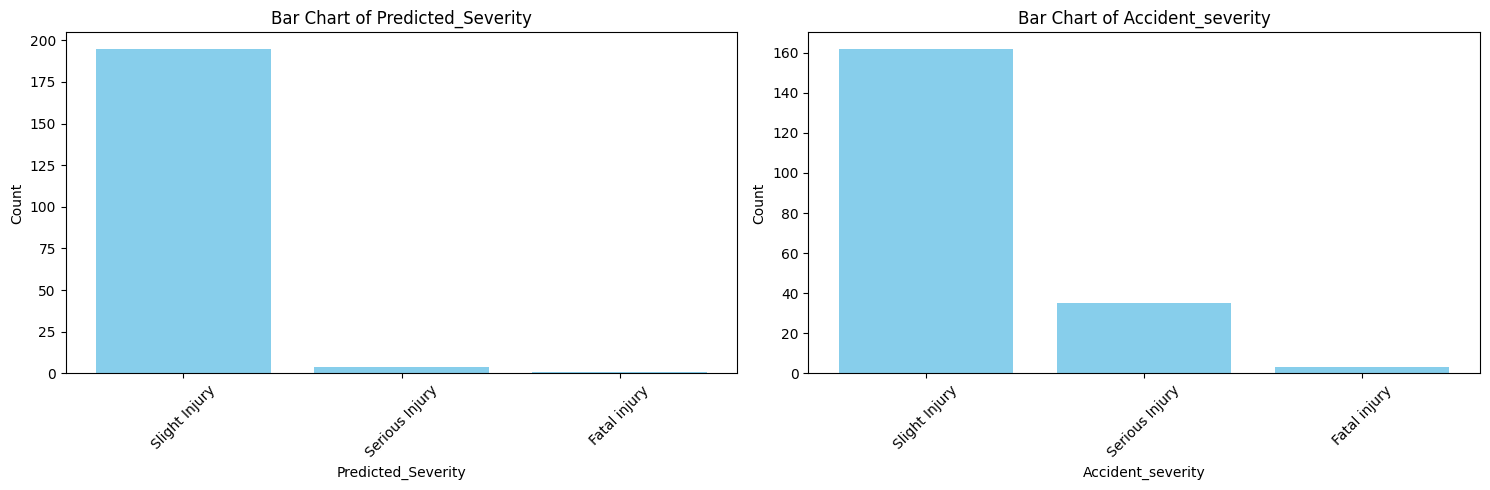

In [107]:
plot_combined_bar_charts(df, ['Predicted_Severity', 'Accident_severity'])

### Pie Chart

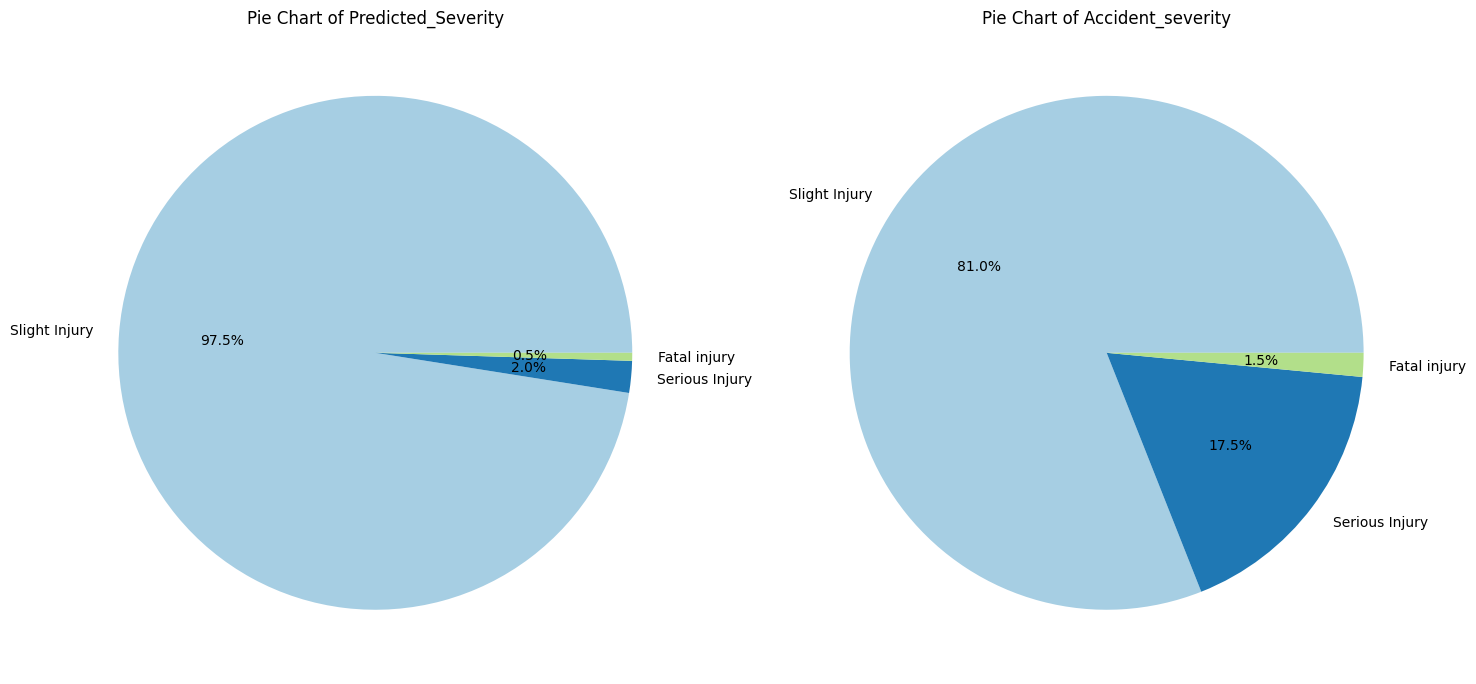

In [108]:
plot_combined_pie_charts(df, ['Predicted_Severity', 'Accident_severity'])